# Dataset From Files

So far, we have been using datasets that are already available in PyTorch. However, in real-world scenarios, we often have to work with datasets that are stored as image files on disk. In this tutorial, we will learn how to load a dataset from files, preprocess it, and divide it into training and test sets.


In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as v2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pathlib

## Data Preparation

We will download the cats-vs-dogs dataset that was made available by Kaggle as part of a computer vision competition in late 2013. This dataset contains 25'000 images of dogs and cats (12'500 from each class) and is 787MB large. The images are medium-resolution color JPEGs.

In [2]:
import os
import zipfile
import tarfile

def download_file(url, save_dir):

    # Set up the save directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Define the file path
    filename = os.path.basename(url)
    filepath = os.path.join(save_dir, filename)

    # Download the file
    if not os.path.exists(filepath):
        torch.hub.download_url_to_file(url, filepath)
    else:
        print(f"Using cached file: {filepath}")

    # Extract the file
    if filepath.endswith('.zip'):
        print(f"Extracting: {filepath}")
        with zipfile.ZipFile(filepath, 'r') as zip_ref:
            zip_ref.extractall(save_dir)
            
    elif filepath.endswith(('.tar', '.tar.gz', '.tgz', '.tar.bz2', '.tbz', '.tar.xz', '.txz')):
        print(f"Extracting: {filepath}")
        with tarfile.open(filepath, 'r:*') as tar_ref:
            tar_ref.extractall(save_dir)

In [3]:
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
folder = ".data/cats_vs_dogs"

download_file(url, folder)

data_dir = pathlib.Path(folder) / "PetImages"

Using cached file: .data/cats_vs_dogs/kagglecatsanddogs_5340.zip
Extracting: .data/cats_vs_dogs/kagglecatsanddogs_5340.zip


### Removing Corrupted Images

When working with lots of real-world image data, corrupted images are a common occurrence. A simple way to check for corrupted images is to read the first few bytes of each file and check if it contains the string "JFIF", which is a standard part of the header of valid JPEG files. If this string is not present, then the image is either corrupted or in a different format. We will use this property to identify and remove badly-encoded images from the dataset.

<!-- Additionally, as an extra precaution, we can read and write all the images to ensure that they are in a consistent format. -->

In [4]:
num_skipped = 0

for path in data_dir.rglob("*.jpg"):

    # Check header
    with open(path, "rb") as file:
        delete = b"JFIF" not in file.peek(10)

    # Read/Write image
    #if not delete:
    #    img = plt.imread(path)
    #    plt.imsave(path, img)

    # Delete image with bad header
    if delete:
        num_skipped += 1
        os.remove(path)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Class `ImageFolder`

Currently, the images sit on a drive as JPEG files. They must be loaded into memory and preprocessed before being passed to a neural network. This involves the following steps:
 - Read a picture file.
 - Decode the JPEG content to RBG grids of pixels.
 - Convert it into a floating-point tensor properly preprocessed.

TorchVision provides a utility class called [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) that does all this for us. It is designed for loading an image dataset organized in a specific directory structure. Within the root directory, each subfolder represents a class, and the images contained in that folder are treated as belonging to that class. For example, in the cats-vs-dogs dataset, the root directory should have two subfolders. The `Cat` subfolder contains images that belong to the "cat" class, and the `Dog` subfolder contains images that belong to the "dog" class. The structure looks like the following.

```
Dataset/
│
├── Cat/
│   ├── cat001.jpg
│   ├── cat002.jpg
│   └── ...
│
└── Dog/
    ├── dog001.jpg
    ├── dog002.jpg
    └── ...
```

We will use the `ImageFolder` class to load the cats-vs-dogs dataset. But first, we need to define the preprocessing steps that we will apply to the images.

<!--
The ImageFolder class takes the path to the dataset directory as an argument, and automatically assigns labels to the images based on the names and the order of the subfolders. In addition, it also has the `transform` and `target_transform` arguments, which accept a callable that preprocesses the images and the labels, respectively. 
-->

### Preprocessing

The `ImageFolder` class requires the path to the root directory of the dataset. It also takes optional arguments that specify how the images and the labels should be preprocessed. Specifically, the `transform` argument accepts a callable that is applied to the images after they are read, and the `target_transform` argument acceps a callable that is applied to the labels.

Let's build a preprocessing pipeline for the cats-vs-dogs dataset that does the following.

 - Convert a PIL image to a PyTorch tensor (more precisely, the subclass `Image` provided by TorchVision).

 - Resize the image to the specified size.

 - Crop the image at the center to have a square shape (without changing the aspect ratio).

 - Convert the pixel values to floats, and normalize them to the range [0, 1].

This pipeline will be passed to the `transform` argument of the `ImageFolder` class.

In [5]:
preprocess = v2.Compose([
    v2.ToImage(),
    v2.Resize(128),
    v2.CenterCrop(128),
    v2.ToDtype(torch.float32, scale=True),
])

We have already seen the transformations [`ToImage()`](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToImage.html) and [`ToDtype()`](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToDtype.html) in a previous tutorial. Let's take a moment to understand the transformations `Resize()` and `CenterCrop()` added to the pipeline.

#### Resize

The [Resize transform](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.Resize.html) modifies the size of the input image. The first argument `size` is mandatory and can be an integer, a tuple, or None. The behavior of the transform depends on the value passed to this argument.

 - If `size` is a tuple (height, width), the output size will be matched to this tuple.

 - If `size` is an integer, the smaller edge of the image will be matched to this number, and the larger edge will be scaled to maintain the aspect ratio. For example, if height > width, the image will be rescaled to (size * height / width, size).

 - If `size` is None, the optional argument `max_size` must be set to an integer. Then the larger edge of the image will be matched to this number, and the smaller edge will be scaled to maintain the aspect ratio. For example, if height > width, the image will be rescaled to (max_size, max_size * width / height).

Let's see an example of how the Resize transform works.

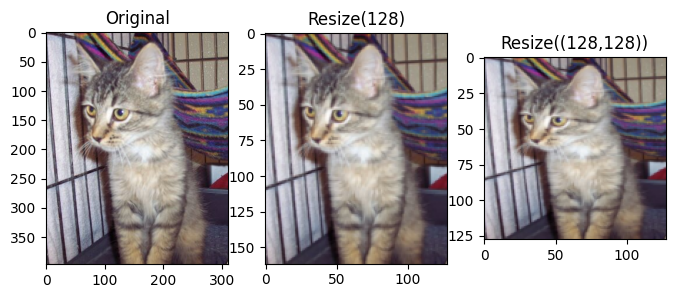

In [6]:
from PIL import Image

original = Image.open(data_dir / "Cat" / "2.jpg")
resized1 = v2.Resize(128)(original)
resized2 = v2.Resize((128,128))(original)

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(resized1)
plt.title("Resize(128)")
plt.subplot(1, 3, 3)
plt.imshow(resized2)
plt.title("Resize((128,128))")
plt.show()

#### Center Crop

The [CenterCrop transform](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.CenterCrop.html) crops the input image at the center.
 - If the `size` argument is an integer, the output size will be (size, size). 
 - If the `size` argument is a tuple (height, width), the output size will be matched to this. 

Let's see an example of how the CenterCrop transform works. Note that the combination of Resize and CenterCrop works well to resize the image to a square shape without changing the aspect ratio.

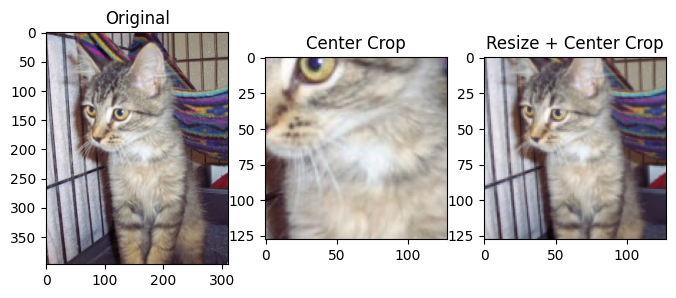

In [7]:
original = Image.open(data_dir / "Cat" / "2.jpg")
crop1 = v2.CenterCrop(128)(original)
crop2 = v2.Compose([v2.Resize(128), v2.CenterCrop(128)])(original)

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(crop1)
plt.title("Center Crop")
plt.subplot(1, 3, 3)
plt.imshow(crop2)
plt.title("Resize + Center Crop")
plt.show()

#### And more...

There are many other transformations available in TorchVision. This [example](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html) provides a visual illustration of several transformations. For the complete list of transformations, please refer to the [documentation](https://pytorch.org/vision/main/transforms.html#v2-api-reference-recommended).

### Splitting the Dataset

The cats-vs-dogs dataset is not divided into training and test sets. We need to split it ourselves. There are several ways to split a dataset in PyTorch.
 - Use the function [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) to randomly split the dataset into non-overlapping subsets.
 - Use the class [Subset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) to create a new dataset from a subset of elements of another dataset.
 - Manually separate the image files into two directories: one for training and one for testing.
 
We will use the second method to split the cats-vs-dogs dataset into training and test sets. Specifically, we will use the `train_test_split` function from the `sklearn` library to generate the indices for the training and test sets. This function will ensure that the distribution of the classes in the training and test sets is similar to the distribution in the original dataset.

In [8]:
# Load the full dataset
dataset = torchvision.datasets.ImageFolder(data_dir, transform=preprocess)

# Split the indices
train_idx, test_idx = train_test_split(range(len(dataset)), stratify=dataset.targets, test_size=0.2, shuffle=True, random_state=42)

# Create the subsets
train_ds = torch.utils.data.Subset(dataset, train_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

Let's print some information about the datasets to verify that everything is working as expected.

In [9]:
dataset_count = torch.bincount(torch.tensor(dataset.targets)) / len(dataset) * 100
train_count = torch.bincount(torch.tensor([dataset.targets[i] for i in train_idx])) / len(train_idx) * 100
test_count = torch.bincount(torch.tensor([dataset.targets[i] for i in test_idx])) / len(test_idx) * 100

print(f"Total images: {len(dataset):5d}",  '|', f'Class distribution: {dataset_count[0].item():.2f}% - {dataset_count[1].item():.2f}%')
print(f"Train set:    {len(train_ds):5d}", '|', f'Class distribution: {train_count[0].item():.2f}% - {train_count[1].item():.2f}%')
print(f"Test set:     {len(test_ds):5d}",  '|', f'Class distribution: {test_count[0].item():.2f}% - {test_count[1].item():.2f}%')

Total images: 23410 | Class distribution: 50.15% - 49.85%
Train set:    18728 | Class distribution: 50.15% - 49.85%
Test set:      4682 | Class distribution: 50.15% - 49.85%


### Visualization

As a last check, we will visualize some images from the training and test sets to ensure that they are loaded correctly and that the preprocessing steps are applied as expected.

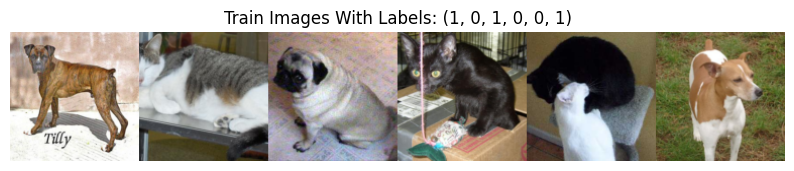

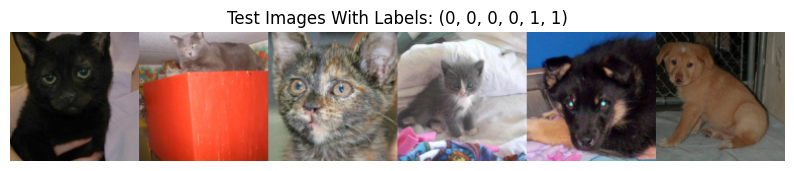

In [10]:
def show_images(dataset, n=6, prefix=""):
    images, labels = zip(*[dataset[i] for i in range(n)])
    side_by_side = torch.cat(images, dim=2)
    side_by_side = side_by_side.permute(1, 2, 0) # from channel-first to channel-last

    plt.figure(figsize=(10,10))
    plt.imshow(side_by_side, cmap='gray')
    plt.title(prefix + " Images With Labels: " + str(labels))
    plt.axis('off')
    plt.show()


show_images(train_ds, prefix="Train")
show_images( test_ds, prefix="Test")

## Baseline model

We will train a simple convolutional network on the cats-vs-dogs dataset. The model consists of several convolutional layers mixed with max-pooling layers, followed by a fully-connected layer and a single-output layer for binary classification. The sigmoid activation is not included in the model because we will use [`nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), which combines the sigmoid activation and the binary cross-entropy loss.

In [11]:
class BaselineModel(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        ksize = 3
        self.conv1 = torch.nn.Conv2d(3, 32, ksize)
        self.conv2 = torch.nn.Conv2d(32, 64, ksize)
        self.conv3 = torch.nn.Conv2d(64, 128, ksize)
        self.conv4 = torch.nn.Conv2d(128, 128, ksize)
        flat_dim = self.__calc_dim(128) # Assume 128x128 images
        self.fc1 = torch.nn.Linear(flat_dim, 256)
        self.fc2 = torch.nn.Linear(256, 1)

    def forward(self, x):
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            x = F.relu(conv(x))
            x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def __calc_dim(self, input_dim: int):
        """Returns the tensor size after the flatten layer."""
        n = input_dim
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            n = n - conv.kernel_size[0] + 1 # CONV output size
            n = n // 2                      # POOL output size
        dim = n * n * self.conv4.out_channels
        return dim

Let's take a look at how the dimensions of the feature maps change with every successive layer. Here, since we start from inputs of size 128x128 (a somewhat arbitrary choice), we end up with feature maps of size 6x6 right before the flatten layer. Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 126x126 to 6x6). This is a pattern that you will see in almost all convnets.

| Layer | Output Shape |
|-------|--------------|
| Input |  (..., 3, 128, 128)
| Conv1 | (..., 32, 126, 126)
| Pool1 | (..., 32, 63,  63)
| Conv2 | (..., 64, 61,  61)
| Pool2 | (..., 64, 30,  30)
| Conv3 | (..., 128, 28, 28)
| Pool3 | (..., 128, 14, 14)
| Conv4 | (..., 128, 12, 12)
| Pool4 | (..., 128, 6, 6)
| Flatten | (..., 4608)
| FC1 | (..., 512)
| FC2 | (..., 1)

### Output shape

As a sanity check, let's pass a batch of 3x128x128 images through the network and check the output shape. Note that the model outputs a 2D tensor of shape `(batch_size, 1)`, where the second dimension is the number of neurons in the output layer, which is 1 in this case.

In [12]:
batch = torch.rand(16, 3, 128, 128)

model = BaselineModel()
output = model(batch)

print("Input shape:", *batch.shape)
print("Output shape:", *output.shape)

Input shape: 16 3 128 128
Output shape: 16 1


```{note}
The model outputs a 2D tensor, even thought the last layer is a single neuron.
```

## Training

Now let's train the baseline model on the cats-vs-dogs dataset. We will reuse the `trainer` function from a [previous tutorial](../mlp/mlp-3.ipynb), which is defined in the [`train.py`](../../code/train.py) script. However, we will pass an additional argument to the `trainer` function to monitor the loss on the test set during training.

In [13]:
import sys
sys.path.append('../../code')  # folder with files: train.py, eval.py, metrics.py

from train import trainer
from eval import Evaluator
from metrics import binary_accuracy

### Class `Evaluator`

We will define a new class called `Evaluator` that provides a structured and flexible approach to evaluating a PyTorch model on a dataset. It automates the evaluation loop, making it easy to compute multiple metrics.

- **Initialization.** The Evaluator is initialized with a dataset and a batch size. It creates a DataLoader for efficient batch processing and maintains a dictionary of evaluation metrics.

- **Adding Metrics.** Metrics can be added dynamically using the `add_metric` method. If a callable function is provided, it is wrapped inside an `AverageMetric` instance, which computes the average value of the metric over the dataset.

- **Evaluation.** The `evaluate` method performs the evaluation loop and returns the computed metric values in a dictionary. It sets the model to evaluation mode, iterates over the dataset, computes predictions with gradients disabled, and updates each metric using the predictions and the targets.

```{note}
The `Evaluator` class is defined in the [`eval.py`](../../code/eval.py) file. Its implementation depends on the `Metric` and `AverageMetric` classes defined in the [`metrics.py`](../../code/metrics.py) file.
```

In [14]:
from display import print_code
print_code("evaluator")

class Evaluator:

    def __init__(self, dataset: Dataset, batch_size: int):
        self.loader = DataLoader(dataset, batch_size)
        self.metrics : dict[str, Metric] = {}

    def add_metric(self, name: str, metric: Union[Metric, Callable]):
        if isinstance(metric, Metric):
            self.metrics[name] = metric
        elif callable(metric):
            self.metrics[name] = AverageMetric(metric)   
        else:
            raise ValueError("metric must be a callable or a Metric object")

    def evaluate(self, model: torch.nn.Module, device: torch.device = None):

        # Check if metrics have been added
        if not self.metrics:
            raise ValueError("No metrics have been added to the evaluator")
        
        # Get model device
        model_device = next(model.parameters()).device

        # Use model device if no device is provided
        if device is None:
            device = model_device

        # Send model to device
        if model_device != device:
            model.to(device)
        
        # Set model to evaluation mode
        model.eval()

        # Reset metrics
        for metric in self.metrics.values():
            metric.reset()
        
        # Loop over the dataset
        for inputs, targets in self.loader:
        
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
        
            # Forward pass
            with torch.inference_mode():
                outputs = model(inputs)
        
            # Evaluate metrics
            for metric in self.metrics.values():
                metric.update(outputs, targets)

        # Bring model back to its original device
        if model_device != device:
            model.to(model_device)

        # Return final metrics
        return {name: metric.compute() for name, metric in self.metrics.items()}

### BCE With Logits Loss

There is a potential pitfall in the binary cross-entropy function provided by PyTorch. This function expects the predictions and the targets to have the same shape. In our case, the prediction is a 2D tensor of shape `(batch_size, 1)`, while the target is a 1D tensor of shape `(batch_size,)`. A simple solution is to remove the singleton dimension from the predictions before passing them to the loss function, as shown below.

In [15]:
def loss_fn(output, target): 
    return F.binary_cross_entropy_with_logits(output.squeeze(), target.float())

### Training Loop





We train the network for a few epochs using the binary cross-entropy loss function defined above. We use a smaller learning rate of 1e-4 because the model is more complex.

**WARNING:** The code below may take a long time to run without a GPU (about 3~4 minutes per epoch).

In [16]:
model = BaselineModel()

loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

evaluator = Evaluator(test_ds, batch_size=128)
evaluator.add_metric("test", loss_fn)

history = trainer(model, loader, loss_fn, optimizer, epochs=10, evaluator=evaluator)

===== Training on mps device =====


Epoch 10/10: 100%|██████████| 293/293 [02:56<00:00,  1.66it/s, test=0.397, train_loss=0.38]


Let's plot the loss of the model computed on the training and test sets. In general, we should see that the training loss decreases over time, while the test loss decreases initially but then flattens out. The gap between the training and test losses indicates the amount of overfitting. In this particular case, the overfitting is minimal, since we stopped training early.

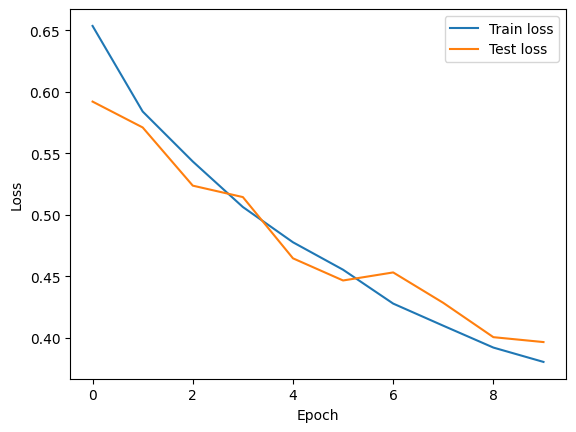

In [17]:
plt.plot(history['train'], label='Train loss')
plt.plot(history['test'], label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

Finally, we evaluate the model on the test set and print the classification accuracy. A simple way to achieve this is to create a new Evaluator, add the `binary_accuracy` metric, and then call the `evaluate` method.

In [18]:
perf_eval = Evaluator(test_ds, batch_size=128)
perf_eval.add_metric("accuracy", binary_accuracy)
metrics = perf_eval.evaluate(model)

print(f"Test Accuracy: {metrics['accuracy']:.2%}")

Test Accuracy: 81.78%


## Summary

In this tutorial, we learned how to load a dataset from files, preprocess it, and divide it into training and test sets. We also trained a simple convolutional network on the cats-vs-dogs dataset, monitored its performance during training, and evaluated its accuracy after training. We also introduced the `Evaluator` class, which provides a structured and flexible approach to evaluating a PyTorch model on a dataset.